# LetNet5

In [11]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

## Preparation

In [12]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transforms, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transforms)

## Show demo data

Text(10, -2, 'The label is 5')

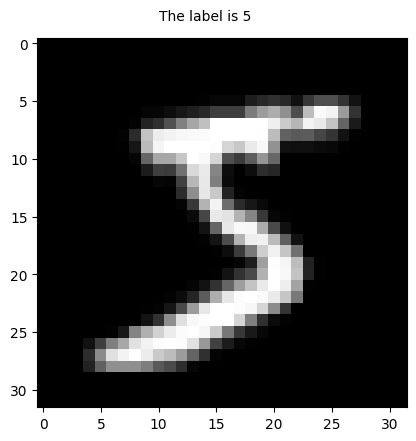

In [13]:
plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.text(10, -2, "The label is " + str(train_dataset[0][1]))

## Define Hyper Parameters

In [14]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [15]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define functions

In [16]:
def train(train_loader, model, criterion, optimizer):
    """
    Train one epoch.
    """

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [17]:
def validate(valid_loader, model, criterion):
    """
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [18]:
def get_accuracy(model, data_loader):
    """
    Function for computing the accuracy of the predictions over the entire data_loader
    """

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def plot_performance(performance):
    """
    Function for plotting training and validation losses
    """

    # temporarily change the style of the plots to seaborn
    # plt.style.use("seaborn")

    fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))
    for key, value in performance.items():
        if "loss" in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs", xlabel="Epoch", ylabel="Loss")
    ax[1].set(title="accuracy over epochs", xlabel="Epoch", ylabel="Loss")
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use("default")

In [19]:
def training_loop(
    model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1
):
    """
    Function defining the entire training loop
    """

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():  # deactivate autograd, reduces memory usage and speeds up computations
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(
                model,
                train_loader,
            )
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(
                f"{datetime.now().time().replace(microsecond=0)} "
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}"
            )

    performance = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

    return model, optimizer, performance

## Define Network Model

In [20]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [21]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()

        self.all_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.all_layers.append(
                nn.Linear(in_features=layers[i - 1], out_features=layers[i])
            )
            if i != len(layers) - 1:
                self.all_layers.append(nn.Tanh())
        self.all_layers = nn.Sequential(*self.all_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.all_layers(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## Begin

In [22]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [23]:
model, optimizer, performance_1 = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS
)

22:09:18 Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
22:09:49 Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
22:10:21 Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
22:10:52 Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
22:11:23 Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.74
22:11:55 Epoch: 5	Train loss: 0.0297	Valid loss: 0.0440	Train accuracy: 99.42	Valid accuracy: 98.63
22:12:27 Epoch: 6	Train loss: 0.0243	Valid loss: 0.0471	Train accuracy: 99.37	Valid accuracy: 98.51
22:12:59 Epoch: 7	Train loss: 0.0219	Valid loss: 0.0477	Train accuracy: 99.43	Valid accuracy: 98.57
22:13:32 Epoch: 8	Train loss: 0.0191	Valid loss: 0.0402	Train accuracy: 99.68	Valid accuracy: 98.76
22:14:04 Epoch: 9	Train loss: 0.0166	Valid loss: 0.0494	Train accuracy: 99.55	Valid accuracy: 98.68


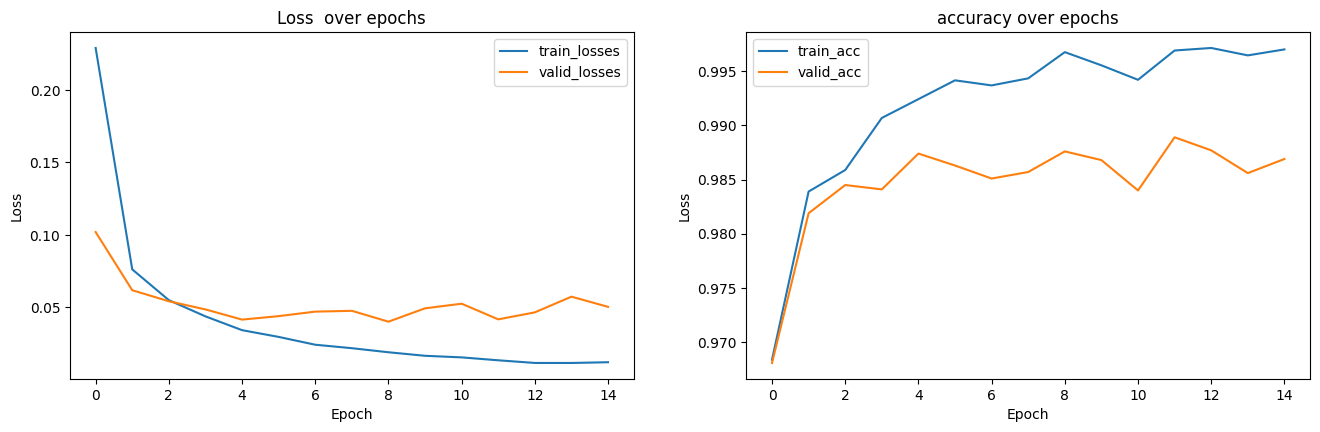

In [24]:
plot_performance(performance_1)

In [25]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (all_layers): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [26]:
model, optimizer, performance_2 = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS
)

22:16:52 Epoch: 0	Train loss: 0.3575	Valid loss: 0.1636	Train accuracy: 95.61	Valid accuracy: 95.23
22:17:00 Epoch: 1	Train loss: 0.1307	Valid loss: 0.1195	Train accuracy: 97.27	Valid accuracy: 96.37
22:17:07 Epoch: 2	Train loss: 0.0922	Valid loss: 0.1063	Train accuracy: 97.71	Valid accuracy: 96.84
22:17:14 Epoch: 3	Train loss: 0.0707	Valid loss: 0.0881	Train accuracy: 98.37	Valid accuracy: 97.42
22:17:21 Epoch: 4	Train loss: 0.0586	Valid loss: 0.0858	Train accuracy: 98.39	Valid accuracy: 97.42
22:17:28 Epoch: 5	Train loss: 0.0518	Valid loss: 0.0767	Train accuracy: 98.98	Valid accuracy: 97.81
22:17:35 Epoch: 6	Train loss: 0.0428	Valid loss: 0.0802	Train accuracy: 99.11	Valid accuracy: 97.64
22:17:41 Epoch: 7	Train loss: 0.0396	Valid loss: 0.0816	Train accuracy: 99.15	Valid accuracy: 97.54
22:17:48 Epoch: 8	Train loss: 0.0333	Valid loss: 0.0857	Train accuracy: 99.19	Valid accuracy: 97.58
22:17:55 Epoch: 9	Train loss: 0.0300	Valid loss: 0.0822	Train accuracy: 99.19	Valid accuracy: 97.55


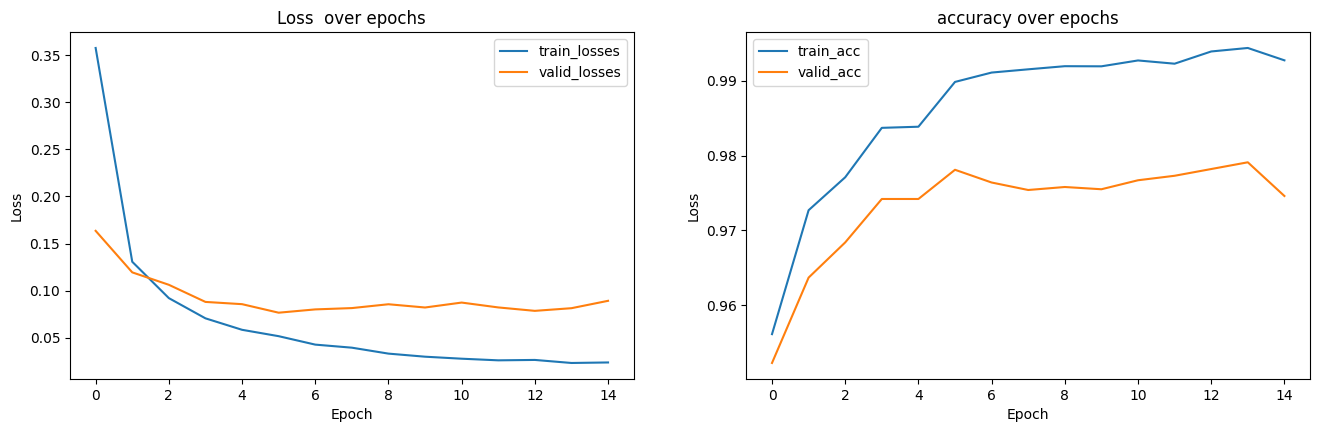

In [27]:
plot_performance(performance_2)

## Comparison of these two models.

Convolutional Layers: parameters = (input_channel \* filter_size + 1) \* output_channel

Fully Connected Layers: parameters = input_channel \* output_channel + output_channel

1. What is the number of trainable parameters of LeNet?

- Convolutional Layers 1: (5\*5\*1+1) \* 6 = 156
- Convolutional Layers 2: (5\*5\*6+1) \* 16 = 2416
- Convolutional Layers 3: (5\*5\*16+1) \* 120 = 48120
- Fully Connected Layers 1: 120\*84+84 = 10164
- Fully Connected Layers 2: 84\*10+10 = 850
- Total: 156 + 2416 + 48120 + 10164 + 850 = 61706

2. What is the number of trainable parameters of MLP?

- Fully Connected Layers 1: 1024\*256+256 = 262400
- Fully Connected Layers 2: 256\*64+64 = 16448
- Fully Connected Layers 3: 64\*16+16 = 1040
- Last Fully Connected Layers: 16\*10+10 = 170
- Total: 262400 + 16448 + 1040 + 170 = 280058

3. Which model has better performance in terms of prediction accuracy on the test data? Give a reason why this model works better than the other. 10 points

LeNet is better.

When using MLP to process images, it is often necessary to flatten the image from its original form into a one-dimensional vector. This flattening process destroys the spatial relationship between pixels.

LeNet is able to understand the spatial relationship between pixels in an image
